In [183]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
     $('div.prompt').hide();
     $('div.input').hide();
 } else {
     $('div.input').show();
     $('div.prompt').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the code."></form>
''')

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy import stats
pd.options.display.max_rows = 100000

In [2]:
df = pd.read_csv("data/global_warming/GlobalLandTemperaturesByCity.csv", parse_dates=[0])

In [3]:
print(df.columns.to_list())

['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude']


In [4]:
df.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object

## Data Quality Assessment

There is a large number of NA values, especially for early years, also the number of observation reported for early years is much lower, due to the fact that there weren't measurements for certain cities, or that city perhaps not developed yet.

In [5]:
df_counts = (df.groupby(df.dt.dt.year)
             .count()
             .rename(columns={"dt":"total_counts","AverageTemperature":"Not_na_counts"})
             .reset_index()
            )

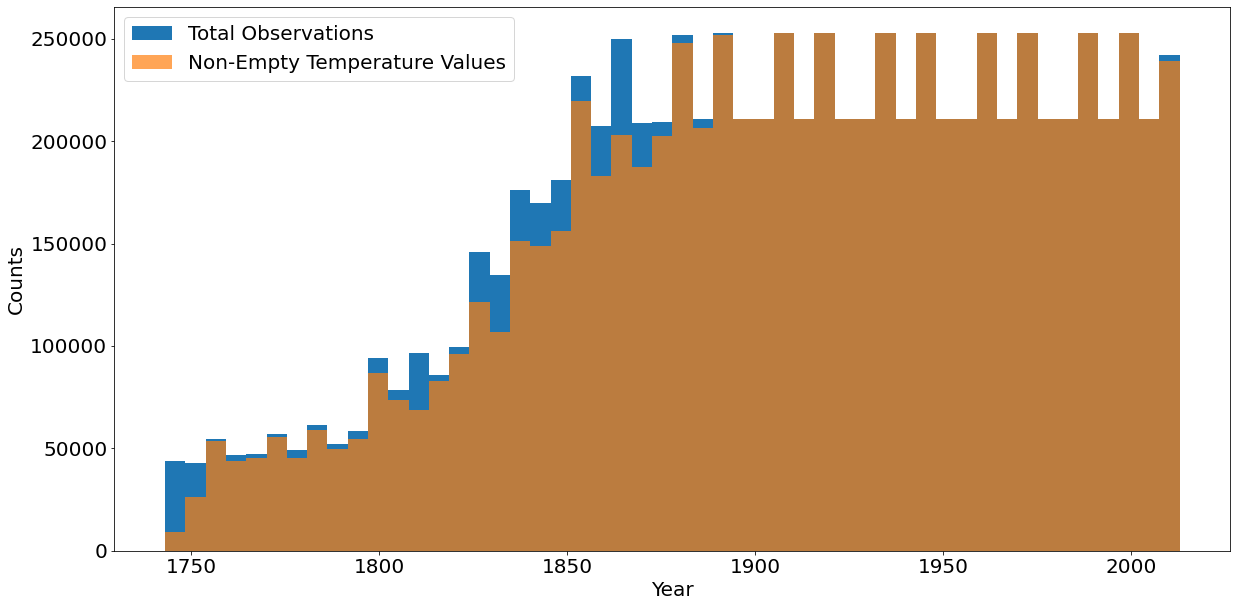

In [6]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.hist(df_counts.dt, weights=df_counts.total_counts, bins=50 )
plt.hist(df_counts.dt, weights=df_counts.Not_na_counts, bins=50, alpha=0.7)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Counts',fontsize=20)
plt.legend(["Total Observations","Non-Empty Temperature Values"],fontsize=20)
plt.show()

The uncertainty on the temperature has a large variance for years below 1900 and it is relatively higher due to tecnology difference.

<AxesSubplot:xlabel='Year', ylabel='Average Temperature Uncertainty [C]'>

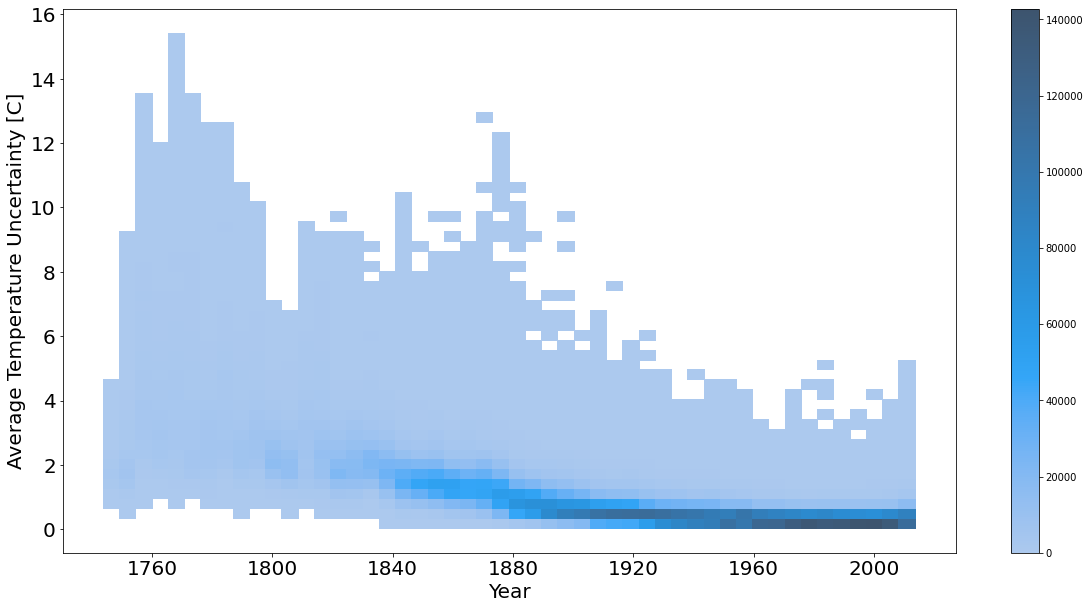

In [7]:
fig, ax2 = plt.subplots(figsize=(20,10))
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Average Temperature Uncertainty [C]',fontsize=20)
sns.color_palette("mako", as_cmap=True)
sns.histplot(x="dt", y="AverageTemperatureUncertainty", data=df, bins=50, cbar=True)

Now in this analysis we need a representative sample of temperatures from the past and a representative sample of temperature of the present. Since the data is by city, and data from many cities are missing in the past this can affect the outcome of the analysis (we need to compare to the same locations). Also the uncertainty of the temperature measurments is correlated with the year, beacuase of technology advancement. We decide then to select data above year 1900, because is more unifor in location, has very few missing values and is more uniform in measurement uncertainty.

## Data Exploration

In [8]:
df_1900 = df.loc[df.dt.dt.year > 1900 ]
df_Rome = df_1900[df_1900.loc[:,"City"] == "Rome" ]
df_Paris = df_1900[df_1900.loc[:,"City"] == "Paris" ]

In [11]:
# adding the column Month and year for easy access
df_Rome = df_Rome.assign(Month=df_Rome.dt.dt.month)
df_Rome = df_Rome.assign(Year=df_Rome.dt.dt.year)

In [22]:
df_Rome_sub_months = df_Rome[df_Rome.Month.isin([1,4,8])]

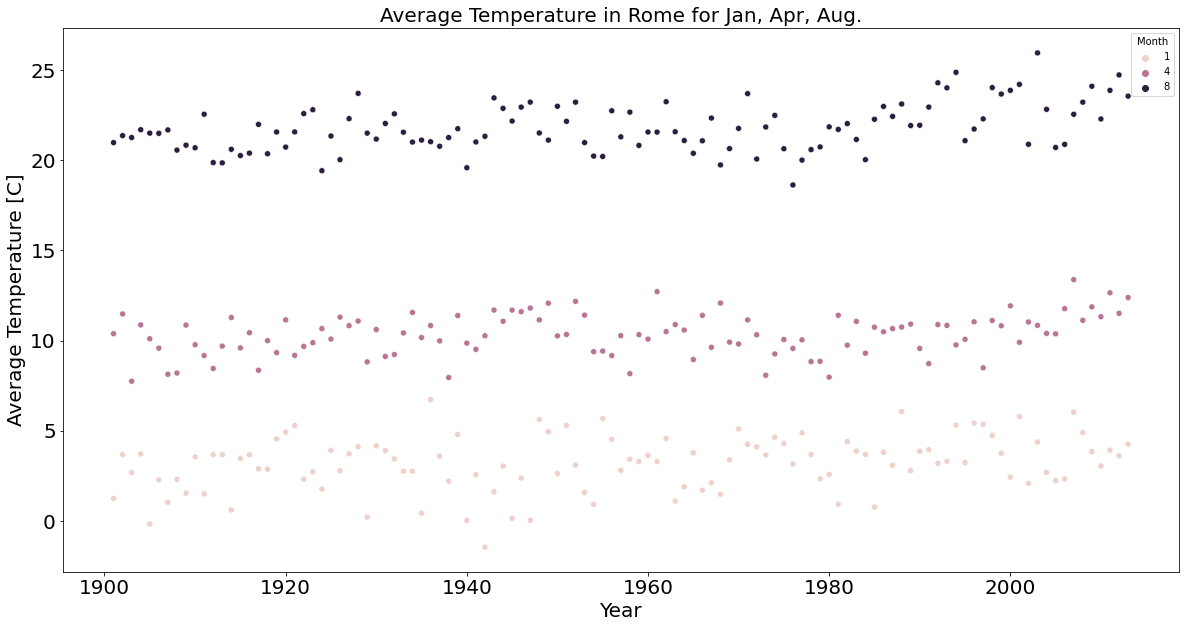

In [32]:
fig, ax3 = plt.subplots(figsize=(20,10))
ax3.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Average Temperature [C]',fontsize=20)
plt.legend(["January","April","August"],fontsize=20)
plt.title("Average Temperature in Rome for Jan, Apr, Aug.", fontsize=20)
sns.scatterplot(x="Year",y="AverageTemperature",data=df_Rome_sub_months, hue="Month", ax=ax3)
plt.show()

In [34]:
# Exercise plot correlation rome Paris and anticorrelation rome-sindey
# done by setting dt as index and aligning the two df
df_Rome_tidx = df_Rome.set_index("dt")
df_Paris_tidx = df_Paris.set_index("dt")


In [36]:
df_Rome_Paris = df_Rome_tidx.assign(Avg_Paris=df_Paris_tidx.AverageTemperature)

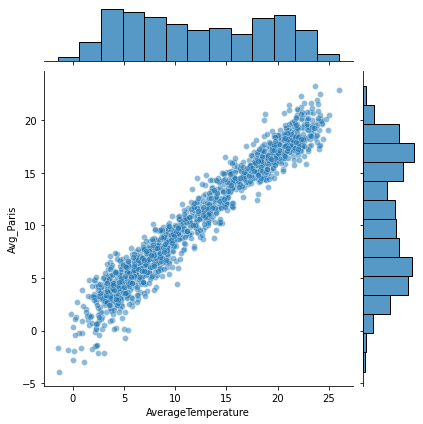

In [38]:
sns.jointplot(data=df_Rome_Paris, x="AverageTemperature",y="Avg_Paris", alpha=0.5)

## Standardized Residuals

In [45]:
df_h0 = df_Rome.loc[df_Rome.dt.dt.year <= 1920]

In [65]:
sn_h0_month_mean = df_h0.groupby(by="Month")["AverageTemperature"].mean()
sn_h0_month_std = df_h0.groupby(by="Month")["AverageTemperature"].std()

In [67]:
df_Rome = df_Rome.assign(std_residual=1.0)

In [63]:
df_h0.groupby(by="Mxonth")["AverageTemperature"].mean()

Month
1      2.69160
2      3.89360
3      7.08555
4      9.73445
5     14.40830
6     18.51060
7     21.16570
8     21.01305
9     17.28700
10    12.34135
11     7.39145
12     4.70220
Name: AverageTemperature, dtype: float64

In [94]:
# filling the std_residuals per month
temp_data = []
for month in list(sn_h0_month_mean.index):
    temp_data.append((df_Rome.loc[df_Rome.Month == month].AverageTemperature - sn_h0_month_mean[month]) / sn_h0_month_std[month])

residuals = pd.concat(temp_data)

In [97]:
df_Rome_residuals = df_Rome.assign(std_residual=residuals)

In [109]:
a_sum_res,bins = np.histogram(df_Rome_residuals.Year, bins=20, weights=df_Rome_residuals.std_residual)
a_sum_n,bins = np.histogram(df_Rome_residuals.Year, bins=20)
a_res_mean = a_sum_res / a_sum_n
years = (bins[:-1:1] + bins[1::1])/2


<ErrorbarContainer object of 3 artists>

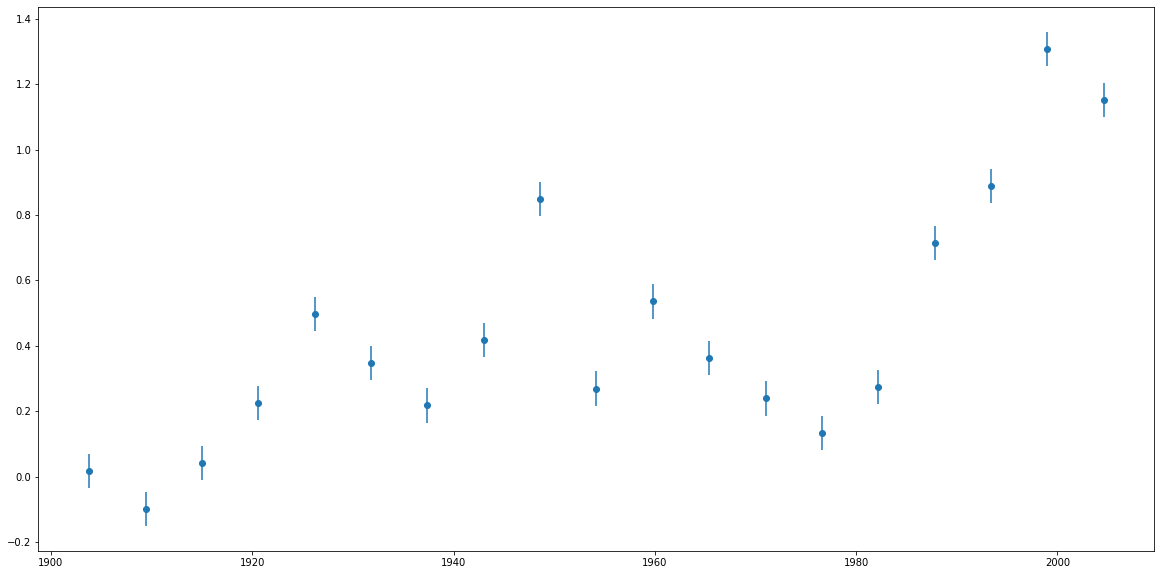

In [121]:
fig, ax4 = plt.subplots(figsize=(20,10))
plt.errorbar(years,a_res_mean, yerr=1/(20-1), fmt="o")

array([1903.8, 1915. , 1926.2, 1937.4, 1948.6, 1959.8, 1971. , 1982.2,
       1993.4, 2004.6])

In [117]:
a_sum_n

array([72, 72, 60, 72, 60, 72, 72, 60, 72, 60, 72, 72, 60, 72, 60, 72, 72,
       60, 72, 69])

In [137]:
df_h1 = df_Rome.loc[(df_Rome.dt.dt.year >= 1993) &( df_Rome.dt.dt.year < 2013)]

In [146]:
sn_h1_month_mean = df_h1.groupby(by="Month")["AverageTemperature"].mean()
sn_h1_month_std = df_h1.groupby(by="Month")["AverageTemperature"].std()

In [151]:
h1_mean = sn_h1_month_mean.sum() / 12


In [64]:
df_h1.groupby(by="Month")[x"AverageTemperature"].mean()

Month
1      3.688857
2      4.533214
3      8.236143
4     11.469357
5     16.312071
6     20.640571
7     23.272714
8     23.118857
9     18.208923
10    13.853538
11     9.026846
12     4.689846
Name: AverageTemperature, dtype: float64

In [154]:
h1_err = np.sqrt(np.square( sn_h1_month_std / np.sqrt(20) ).sum() / 12)

In [158]:
h0_mean = sn_h0_month_mean.sum() / 12
h0_err = np.sqrt(np.square( sn_h0_month_std / np.sqrt(20) ).sum() / 12)

In [176]:
print("The yearly Average H1 temperature is {0:.1f} +- {1:.1f} °C".format(h1_mean,h1_err))
print("The yearly Average H0 temperature is {0:.1f} +- {1:.1f} °C".format(h0_mean,h0_err))

The yearly Average H1 temperature is 13.0 +- 0.3 °C
The yearly Average H0 temperature is 11.7 +- 0.3 °C


In [172]:
t_stat = (h1_mean - h0_mean) / math.sqrt((h0_err)**2 + (h1_err)**2)
p_value = stats.norm.sf(t_stat)
print("the p-value is {0:.5f}".format(p_value))

the p-value is 0.00035


0.6826894921370859